In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import shap


In [8]:
df = pd.read_csv(r'C:\Users\NickBowen\Documents\NFL Data\2024 Weekly Game Data\NFL_TeamGame_Stats2024 - Sheet1.csv')

In [9]:
df.head()

,Week,Team,Opponent,Location,Stadium Type,First Downs,Rushing Attempts,Rushing Yards,Rushing Touchdowns,Passing Completions,...,Total 3rd Down Attempts,Total 3rd Down Completions,3rd Down Conversion,Total 4th Down Attempts,Total 4th Down Completions,4th Down Conversion,Time of Possesion,Points,Opponent Points,Win/Loss
0,1,Ravens,Chiefs,Away,Outdoor,25,32,185,1,26,...,14,7,0.500000,2,1,0.5,33.72,20,27,Loss
1,1,Chiefs,Ravens,Home,Outdoor,21,20,72,2,20,...,9,4,0.444444,0,0,NaN,26.28,27,20,Win
2,1,Packers,Eagles,Home,International,19,21,163,1,17,...,11,3,0.272727,1,1,1.0,27.22,29,34,Loss
3,1,Eagles,Packers,Away,International,25,38,144,2,20,...,14,4,0.285714,1,1,1.0,32.78,34,29,Win
4,1,Steelers,Falcons,Away,Indoor,16,41,137,0,17,...,17,8,0.470588,1,0,0.0,35.60,18,10,Win


In [76]:
# Split the data into features and target
# X = df.drop(['Points','Week','Win/Loss','Opponent Points','Opponent','Team'], axis=1)

#testing to see if this works for output prediction
X = df.drop(['Points','Win/Loss'], axis=1)
y = df['Points']

In [77]:
#defining categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [78]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# Create a column transformer for one-hot encoding and imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Ignore unknown categories
        ]), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), X.select_dtypes(include=['float64', 'int64']).columns)  # Impute missing values with the mean for numerical columns
    ],
    remainder='passthrough'  # Keep the rest of the columns unchanged
)

In [80]:
# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [81]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Team', 'Opponent',
                                                   'Location',
                                                   'Stadium Type']),
                                                 ('num', SimpleImputer(),
                                                  Index(['Week', 'First Downs', 'Rushing Attempts', 'Rus

In [82]:
# Optionally, make predictions
y_pred = pipeline.predict(X_test)

c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Performance Metrics on model output**

In [83]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 4.569000000000001
Mean Squared Error (MSE): 35.52872999999999
R-squared (R²): 0.5387526532731819


**Feature importance and shap analysis**

In [84]:
# Extract feature importances from the trained model
feature_importances = pipeline.named_steps['model'].feature_importances_

In [85]:
# Get the feature names from the preprocessor
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
all_feature_names = np.concatenate([onehot_columns, numeric_columns])

In [86]:
# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

In [87]:
# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

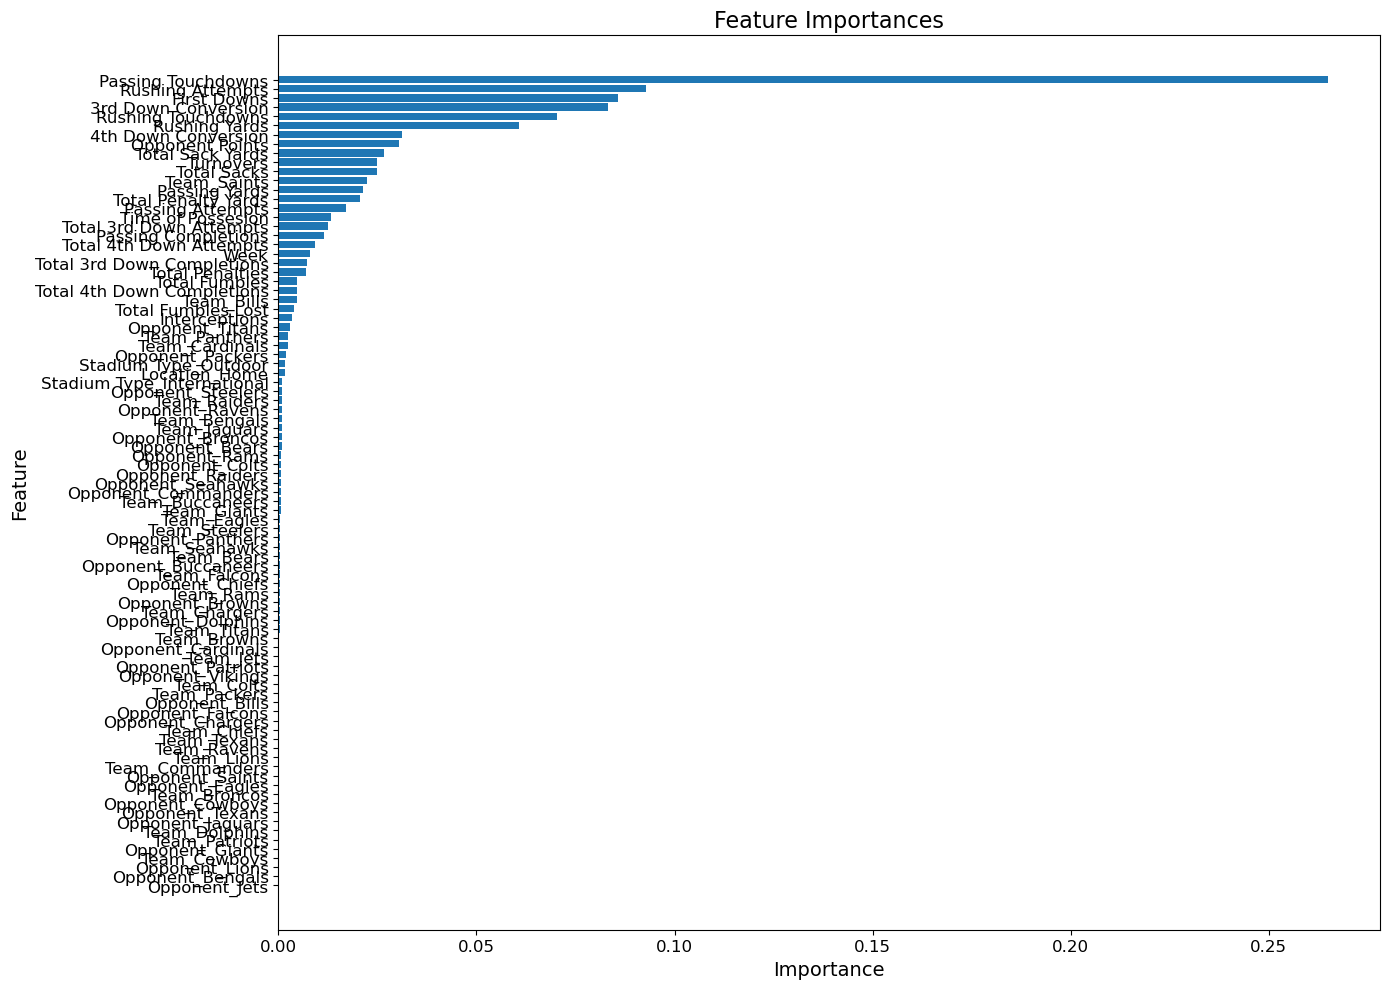

Least impactful features:
             Feature    Importance
41  Opponent_Cowboys  8.345286e-05
58   Opponent_Texans  7.131308e-05
46  Opponent_Jaguars  4.550349e-05
12     Team_Dolphins  3.881931e-05
21     Team_Patriots  2.486957e-05
45   Opponent_Giants  1.859800e-05
11      Team_Cowboys  1.400120e-05
48    Opponent_Lions  1.186555e-05
31  Opponent_Bengals  1.314886e-06
47     Opponent_Jets  7.524276e-07


In [88]:
# Plot the feature importances with adjusted figure size and font size
plt.figure(figsize=(14, 10))  # Increase the figure size
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance', fontsize=14)  # Increase font size for x-axis label
plt.ylabel('Feature', fontsize=14)  # Increase font size for y-axis label
plt.title('Feature Importances', fontsize=16)  # Increase font size for title
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)  # Increase font size for x-axis ticks
plt.yticks(fontsize=12)  # Increase font size for y-axis ticks
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Display the least impactful features
print("Least impactful features:")
print(feature_importance_df.tail(10))

c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


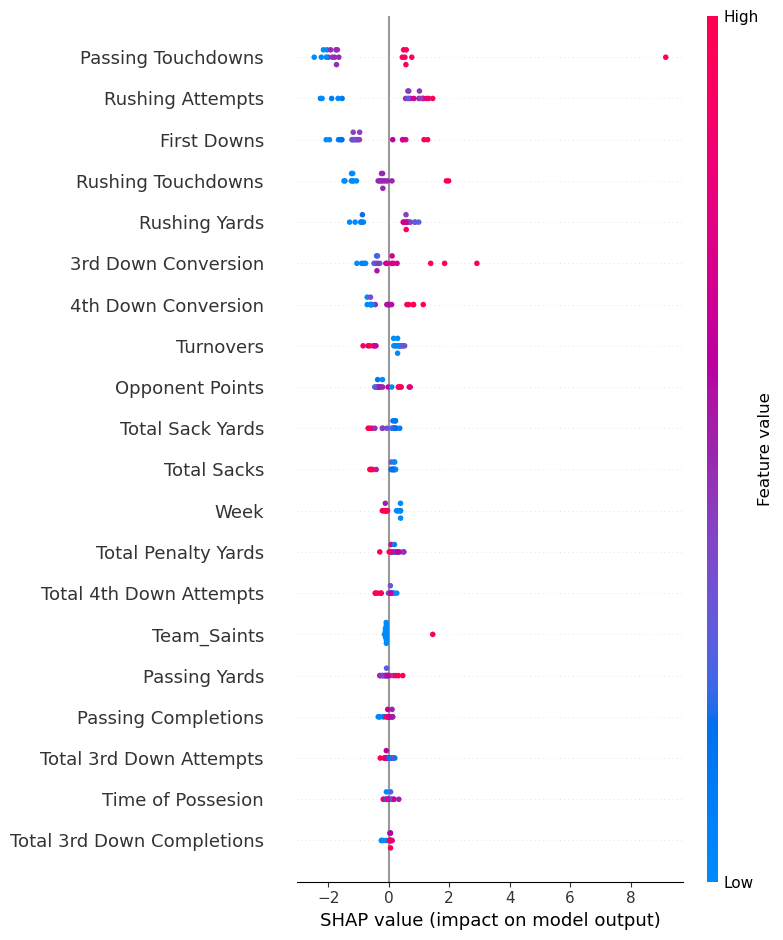

In [89]:
# Create a SHAP explainer using the trained model
explainer = shap.TreeExplainer(pipeline.named_steps['model'])

# Transform the test set using the preprocessor
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# Get the feature names from the preprocessor
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
all_feature_names = np.concatenate([onehot_columns, numeric_columns])

# Create a DataFrame for the transformed test set
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Summary plot
shap.summary_plot(shap_values, X_test_transformed_df, feature_names=all_feature_names)

**Appending results of model to original dataframe to compare results to actuals**

getting errors when merging dataframes due to indicies


In [90]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Create a DataFrame with the actual and predicted values
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['Difference'] = results_df['Actual'] - results_df['Predicted']

# Display the first few rows of the results DataFrame
results_df.head()

c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Week,Team,Opponent,Location,Stadium Type,First Downs,Rushing Attempts,Rushing Yards,Rushing Touchdowns,Passing Completions,...,Total 3rd Down Completions,3rd Down Conversion,Total 4th Down Attempts,Total 4th Down Completions,4th Down Conversion,Time of Possesion,Opponent Points,Actual,Predicted,Difference
80,3,Packers,Titans,Away,Outdoor,16,37,188,1,13,...,5,0.357143,0,0,NaN,32.47,14,30,18.87,11.13
77,3,Vikings,Texans,Home,Indoor,19,28,118,0,17,...,6,0.461538,1,1,1.0,29.30,7,34,30.82,3.18
73,3,Cardinals,Lions,Home,Indoor,17,18,77,0,21,...,1,0.111111,2,0,0.0,23.18,20,13,12.64,0.36
94,3,Commanders,Bengals,Away,Outdoor,22,32,108,3,21,...,5,0.555556,3,3,1.0,33.10,33,38,28.61,9.39
33,2,Dolphins,Bills,Home,Outdoor,20,34,139,0,25,...,7,0.466667,5,1,0.2,36.32,31,10,19.75,-9.75


In [91]:
# Merge the results back into the original DataFrame
df_with_results = df.copy()
df_with_results = df_with_results.merge(results_df[['Actual', 'Predicted', 'Difference']], left_index=True, right_index=True, how='left')

# Display the first few rows of the updated DataFrame
df_with_results.head(50)

,Week,Team,Opponent,Location,Stadium Type,First Downs,Rushing Attempts,Rushing Yards,Rushing Touchdowns,Passing Completions,...,Total 4th Down Attempts,Total 4th Down Completions,4th Down Conversion,Time of Possesion,Points,Opponent Points,Win/Loss,Actual,Predicted,Difference
0,1,Ravens,Chiefs,Away,Outdoor,25,32,185,1,26,...,2,1,0.500000,33.72,20,27,Loss,20.0,23.53,-3.53
1,1,Chiefs,Ravens,Home,Outdoor,21,20,72,2,20,...,0,0,NaN,26.28,27,20,Win,NaN,NaN,NaN
2,1,Packers,Eagles,Home,International,19,21,163,1,17,...,1,1,1.000000,27.22,29,34,Loss,NaN,NaN,NaN
3,1,Eagles,Packers,Away,International,25,38,144,2,20,...,1,1,1.000000,32.78,34,29,Win,NaN,NaN,NaN
4,1,Steelers,Falcons,Away,Indoor,16,41,137,0,17,...,1,0,0.000000,35.60,18,10,Win,18.0,18.29,-0.29
5,1,Falcons,Steelers,Home,Indoor,15,22,89,0,16,...,1,1,1.000000,24.40,10,18,Loss,NaN,NaN,NaN
6,1,Cardinals,Bills,Away,Outdoor,18,25,124,1,21,...,1,0,0.000000,29.50,28,34,Loss,NaN,NaN,NaN
7,1,Bills,Cardinals,Home,Outdoor,23,33,130,2,18,...,2,2,1.000000,30.50,34,28,Win,NaN,NaN,NaN
8,1,Titans,Bears,Away,Outdoor,16,26,140,1,19,...,2,1,0.500000,34.90,17,24,Loss,NaN,NaN,NaN
9,1,Bears,Titans,Home,Outdoor,11,22,84,0,14,...,2,2,1.000000,25.10,24,17,Win,NaN,NaN,NaN


# Predicting upcoming games

In [92]:
print(df.columns)

Index(['Week', 'Team', 'Opponent', 'Location', 'Stadium Type', 'First Downs',
       'Rushing Attempts', 'Rushing Yards', 'Rushing Touchdowns',
       'Passing Completions', 'Passing Attempts', 'Passing Yards',
       'Passing Touchdowns', 'Interceptions', 'Total Sacks',
       'Total Sack Yards', 'Total Fumbles', 'Total Fumbles Lost', 'Turnovers',
       'Total Penalties', 'Total Penalty Yards', 'Total 3rd Down Attempts',
       'Total 3rd Down Completions', '3rd Down Conversion',
       'Total 4th Down Attempts', 'Total 4th Down Completions',
       '4th Down Conversion', 'Time of Possesion', 'Points', 'Opponent Points',
       'Win/Loss'],
      dtype='object')


In [93]:
# Calculate the average statistics for each numerical feature for each team
numerical_features = [
    'First Downs', 'Rushing Attempts', 'Rushing Yards', 'Rushing Touchdowns',
    'Passing Completions', 'Passing Attempts', 'Passing Yards', 'Passing Touchdowns',
    'Interceptions', 'Total Sacks', 'Total Sack Yards', 'Total Fumbles', 'Total Fumbles Lost',
    'Turnovers', 'Total Penalties', 'Total Penalty Yards', 'Total 3rd Down Attempts',
    'Total 3rd Down Completions', '3rd Down Conversion', 'Total 4th Down Attempts',
    'Total 4th Down Completions', '4th Down Conversion', 'Time of Possesion'
]
team_averages = df.groupby('Team')[numerical_features].mean().reset_index()

In [98]:
# Function to get the average game data for a given team
def get_average_game_data(team, team_averages):
    return team_averages[team_averages['Team'] == team].iloc[0]

# Function to get the average game data for a given opponent
def get_average_opponent_data(opponent, team_averages):
    return team_averages[team_averages['Team'] == opponent].iloc[0]

In [99]:
# Example teams for the upcoming week
teams = ['Lions'] #change to allow user to input teams they want to compare

# User input for categorical features
location = input("Enter the location (Home/Away): ")
stadium_type = input("Enter the stadium type (Outdoor/Indoor): ")
opponent = input("Enter the opponent: ")

print(location)
print(stadium_type)
print(opponent)

Home
Indoor
Seahawks


In [100]:
# Prepare the input data for the upcoming games
upcoming_games_data = []

for team in teams:
    average_game = get_average_game_data(team, team_averages)
    opponent = opponent
    average_opponent_game = get_average_opponent_data(opponent, team_averages)
    
    upcoming_game = {
        'Week': 3,
        'Team': team,
        'Opponent': opponent,
        'Location': location,
        'Stadium Type': stadium_type,
        'First Downs': average_game['First Downs'],
        'Rushing Attempts': average_game['Rushing Attempts'],
        'Rushing Yards': average_game['Rushing Yards'],
        'Rushing Touchdowns': average_game['Rushing Touchdowns'],
        'Passing Completions': average_game['Passing Completions'],
        'Passing Attempts': average_game['Passing Attempts'],
        'Passing Yards': average_game['Passing Yards'],
        'Passing Touchdowns': average_game['Passing Touchdowns'],
        'Interceptions': average_game['Interceptions'],
        'Total Sacks': average_game['Total Sacks'],
        'Total Sack Yards': average_game['Total Sack Yards'],
        'Total Fumbles': average_game['Total Fumbles'],
        'Total Fumbles Lost': average_game['Total Fumbles Lost'],
        'Turnovers': average_game['Turnovers'],
        'Total Penalties': average_game['Total Penalties'],
        'Total Penalty Yards': average_game['Total Penalty Yards'],
        'Total 3rd Down Attempts': average_game['Total 3rd Down Attempts'],
        'Total 3rd Down Completions': average_game['Total 3rd Down Completions'],
        '3rd Down Conversion': average_game['3rd Down Conversion'],
        'Total 4th Down Attempts': average_game['Total 4th Down Attempts'],
        'Total 4th Down Completions': average_game['Total 4th Down Completions'],
        '4th Down Conversion': average_game['4th Down Conversion'],
        'Opponent First Downs': average_opponent_game['First Downs'],
        'Opponent Rushing Attempts': average_opponent_game['Rushing Attempts'],
        'Opponent Rushing Yards': average_opponent_game['Rushing Yards'],
        'Opponent Rushing Touchdowns': average_opponent_game['Rushing Touchdowns'],
        'Opponent Passing Completions': average_opponent_game['Passing Completions'],
        'Opponent Passing Attempts': average_opponent_game['Passing Attempts'],
        'Opponent Passing Yards': average_opponent_game['Passing Yards'],
        'Opponent Passing Touchdowns': average_opponent_game['Passing Touchdowns'],
        'Opponent Interceptions': average_opponent_game['Interceptions'],
        'Opponent Total Sacks': average_opponent_game['Total Sacks'],
        'Opponent Total Sack Yards': average_opponent_game['Total Sack Yards'],
        'Opponent Total Fumbles': average_opponent_game['Total Fumbles'],
        'Opponent Total Fumbles Lost': average_opponent_game['Total Fumbles Lost'],
        'Opponent Turnovers': average_opponent_game['Turnovers'],
        'Opponent Total Penalties': average_opponent_game['Total Penalties'],
        'Opponent Total Penalty Yards': average_opponent_game['Total Penalty Yards'],
        'Opponent Total 3rd Down Attempts': average_opponent_game['Total 3rd Down Attempts'],
        'Opponent Total 3rd Down Completions': average_opponent_game['Total 3rd Down Completions'],
        'Opponent 3rd Down Conversion': average_opponent_game['3rd Down Conversion'],
        'Opponent Total 4th Down Attempts': average_opponent_game['Total 4th Down Attempts'],
        'Opponent Total 4th Down Completions': average_opponent_game['Total 4th Down Completions'],
        'Opponent 4th Down Conversion': average_opponent_game['4th Down Conversion']
    }
    upcoming_games_data.append(upcoming_game)

upcoming_games = pd.DataFrame(upcoming_games_data)

In [101]:
# Select only the features needed for prediction
features_for_prediction = numerical_features + ['Location', 'Stadium Type']
upcoming_games_features = upcoming_games[features_for_prediction]

# Transform the input data using the same preprocessing pipeline
upcoming_games_transformed = pipeline.named_steps['preprocessor'].transform(upcoming_games_features)

KeyError: "['Time of Possesion'] not in index"

In [57]:
# Make predictions for the upcoming games
predicted_scores = pipeline.named_steps['model'].predict(upcoming_games_transformed)

# Add the predicted scores to the original DataFrame
upcoming_games['Predicted Points'] = predicted_scores

# Display the predicted scores
print(upcoming_games[['Team', 'Opponent', 'Predicted Points']])

KeyError: "['Team', 'Opponent'] not in index"